# Analyse the Visual Attention Data

In [1]:
import os

import pandas as pd
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import json
import modules.GenSnippetsLib as snippets
import scipy.stats as stats
import scipy.ndimage
from pygments.lexers import PythonLexer
from tqdm import tqdm
import matplotlib.patches as patches
import PIL
import PIL.Image
import numpy as np
import itertools

In [2]:
df = pd.read_csv('./data/preprocessed_experiment_data.csv')
df = df[df["Outlier"] == False]
df = df.drop(columns=["Outlier"])
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData
0,212,iterative,apply,66794,False,268-191 151-70 151-70 146-89 135-12 135-65 120...,10105 34435 35005 39192 47146 56587 61358 66794
1,245,iterative,apply,21078,True,156-17 174-195 129-44 131-62 141-93 141-114 14...,1123 3472 14145 14878 16035 19911 21078
2,272,iterative,apply,81561,True,188-192 104-34 132-69 149-89,16519 78023 79043 81561
3,296,iterative,apply,22825,False,160-195 122-115 148-9 138-34 140-60 132-94 153...,4194 11386 13568 14369 15567 17215 21808 22825
4,302,iterative,apply,20310,True,69-204 84-191 150-197 254-200 183-14 85-36 95-...,4193 5008 5850 6351 8856 10441 11790 13309 20310
...,...,...,...,...,...,...,...
323,213,list-comprehension,LinkedList,153552,False,42-22 65-45 51-123 81-143 111-161 100-143 50-1...,4155 9379 12561 13652 21857 23971 25078 25989 ...
324,252,list-comprehension,LinkedList,47933,True,110-12 118-37 101-117 126-142 134-170 137-190 ...,3853 4218 8660 9020 9434 9893 11026 11335 1200...
326,297,list-comprehension,LinkedList,48782,True,80-9 90-33 88-125 103-146 109-170 114-194 103-...,3545 4213 6711 7143 7700 8598 9962 10333 11843...
327,309,list-comprehension,LinkedList,55439,False,78-15 80-37 81-117 109-146 106-170 106-192 114...,3924 4856 5841 6974 7497 8040 10490 11359 1325...


In [3]:
def click_data_to_list(click_data_string):
    click_data_list = []
    for click in click_data_string.split(" "):
        click = click.split("-")
        # extract the x and y coordinates from a string via regex
        x = int(re.search(r'\d+', click[0])[0])
        y = int(re.search(r'\d+', click[1])[0])
        click_data_list.append((x, y))
    return click_data_list

In [4]:
def time_data_to_list(time_data_string):
    time_data_list = []
    for time in time_data_string.split(" "):
        time_data_list.append(float(time) / 1000)
    return time_data_list

In [5]:
df["ClickData"] = df["ClickData"].apply(lambda x: click_data_to_list(x))
df["TimeData"] = df["TimeData"].apply(lambda x: time_data_to_list(x))
df["NumberOfClicks"] = df["ClickData"].apply(lambda x: len(x))
df["AverageTimeOfClicks"] = (df["ResponseTime"] / 1000) / df["NumberOfClicks"]

In [6]:
df

,ID,ProgrammingStyle,Algorithm,ResponseTime,Correctness,ClickData,TimeData,NumberOfClicks,AverageTimeOfClicks
0,212,iterative,apply,66794,False,"[(268, 191), (151, 70), (151, 70), (146, 89), ...","[10.105, 34.435, 35.005, 39.192, 47.146, 56.58...",8,8.349250
1,245,iterative,apply,21078,True,"[(156, 17), (174, 195), (129, 44), (131, 62), ...","[1.123, 3.472, 14.145, 14.878, 16.035, 19.911,...",7,3.011143
2,272,iterative,apply,81561,True,"[(188, 192), (104, 34), (132, 69), (149, 89)]","[16.519, 78.023, 79.043, 81.561]",4,20.390250
3,296,iterative,apply,22825,False,"[(160, 195), (122, 115), (148, 9), (138, 34), ...","[4.194, 11.386, 13.568, 14.369, 15.567, 17.215...",8,2.853125
4,302,iterative,apply,20310,True,"[(69, 204), (84, 191), (150, 197), (254, 200),...","[4.193, 5.008, 5.85, 6.351, 8.856, 10.441, 11....",9,2.256667
...,...,...,...,...,...,...,...,...,...
323,213,list-comprehension,LinkedList,153552,False,"[(42, 22), (65, 45), (51, 123), (81, 143), (11...","[4.155, 9.379, 12.561, 13.652, 21.857, 23.971,...",51,3.010824
324,252,list-comprehension,LinkedList,47933,True,"[(110, 12), (118, 37), (101, 117), (126, 142),...","[3.853, 4.218, 8.66, 9.02, 9.434, 9.893, 11.02...",39,1.229051
326,297,list-comprehension,LinkedList,48782,True,"[(80, 9), (90, 33), (88, 125), (103, 146), (10...","[3.545, 4.213, 6.711, 7.143, 7.7, 8.598, 9.962...",37,1.318432
327,309,list-comprehension,LinkedList,55439,False,"[(78, 15), (80, 37), (81, 117), (109, 146), (1...","[3.924, 4.856, 5.841, 6.974, 7.497, 8.04, 10.4...",36,1.539972


## Descriptive: Get Number of Clicks per Algorithm

In [7]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
df_visual[["Algorithm", "ProgrammingStyle", "NumberOfClicks"]].groupby(["Algorithm", "ProgrammingStyle"]).describe()

NumberOfClicks                              \
                                          count       mean        std   min   
Algorithm     ProgrammingStyle                                                
LinkedList    higher-order                  5.0  39.800000  21.288495  11.0   
              iterative                     6.0  45.333333  12.785408  33.0   
              list-comprehension            7.0  41.714286  15.923926  25.0   
              recursive                     6.0  31.166667  16.129683   8.0   
apply         higher-order                  8.0   3.500000   0.755929   3.0   
              iterative                     7.0   7.142857   1.676163   4.0   
              list-comprehension            6.0   3.666667   1.211060   3.0   
              recursive                     7.0  20.571429  14.953897   6.0   
computer      higher-order                  7.0  44.142857  35.690468  18.0   
              iterative                     5.0  29.400000   4.774935  25.0   
              list-comprehension            8.0  33.125000  16.348329  19.0   
              recursive                     4.0  26.500000  16.583124   5.0   
condition_sum higher-order                  5.0   6.400000   3.209361   4.0   
              iterative                     7.0  16.857143  10.447146   8.0   
              list-comprehension            7.0   9.428571   3.457222   6.0   
              recursive                     6.0  12.500000   8.093207   6.0   
find          higher-order                  5.0  20.800000  26.499057   7.0   
              iterative                     7.0   9.714286   4.535574   6.0   
              list-comprehension            6.0   5.333333   2.422120   3.0   
              recursive                     6.0  21.500000   7.918333  12.0   
is_prime      higher-order                  7.0  13.285714  13.250337   4.0   
              iterative                     9.0  15.777778  10.732867   8.0   
              list-comprehension            5.0   2.800000   0.836660   2.0   
              recursive                     7.0  12.857143   4.220133   8.0   
max           higher-order                  8.0   7.000000   5.477226   3.0   
              iterative                     6.0  13.000000   6.782330   5.0   
              list-comprehension            7.0   8.428571   4.197505   6.0   
              recursive                     7.0  21.285714  18.364044   7.0   
node          higher-order                  7.0  34.571429  15.778225  10.0   
              iterative                     7.0  40.428571  12.594405  28.0   
              list-comprehension            5.0  36.000000  19.685020  17.0   
              recursive                     5.0  46.000000  17.818530  30.0   
prime_factors higher-order                  7.0  17.857143   8.513295   9.0   
              iterative                     6.0  23.833333   7.704977  17.0   
              list-comprehension            6.0  22.000000  32.631273   4.0   
              recursive                     6.0  51.166667  48.329770  18.0   
quad_mul      higher-order                  5.0   7.000000   1.224745   6.0   
              iterative                     8.0  13.750000   5.922114   9.0   
              list-comprehension            6.0  12.666667  11.075498   6.0   
              recursive                     6.0   5.000000   1.673320   2.0   
store         higher-order                  4.0  51.250000  23.271943  17.0   
              iterative                     6.0  56.833333  23.327380  12.0   
              list-comprehension            6.0  75.333333  36.843814  32.0   
              recursive                     6.0  63.666667  17.750117  33.0   
students      higher-order                  7.0  24.714286  16.007439  11.0   
              iterative                     3.0  22.000000   4.582576  17.0   
              list-comprehension            5.0   5.600000   3.781534   3.0   
              recursive                     6.0  26.833333  24.742002   7.0   
tota

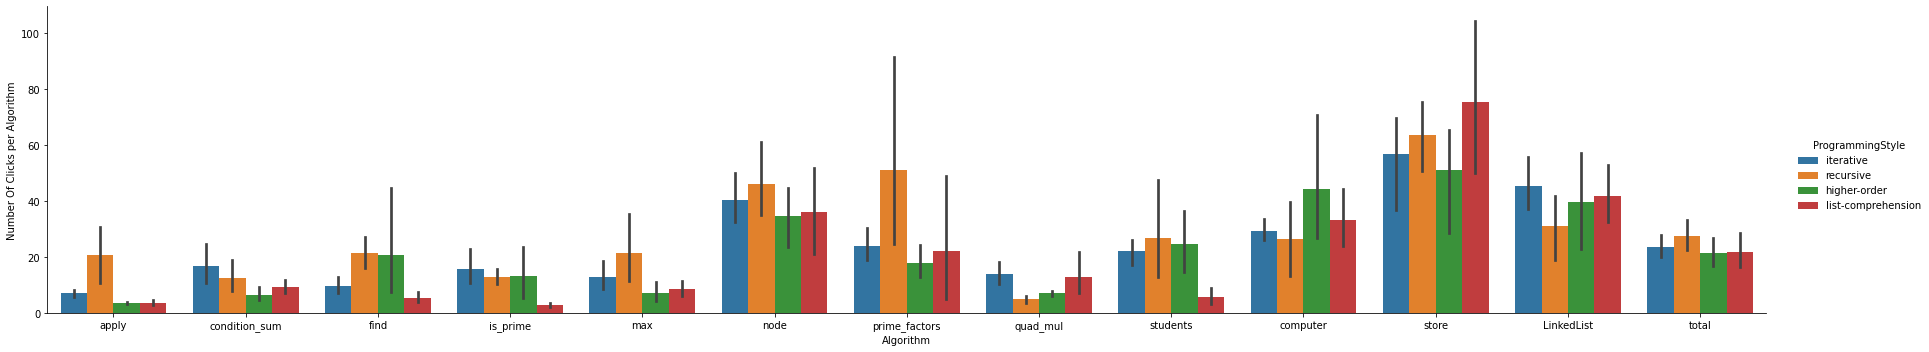

In [8]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
ax = sns.catplot(x="Algorithm", y="NumberOfClicks", hue="ProgrammingStyle", data=df_visual, kind="bar", height=5,
                 aspect=5)
ax.tight_layout()
ax.set(ylabel='Number Of Clicks per Algorithm');

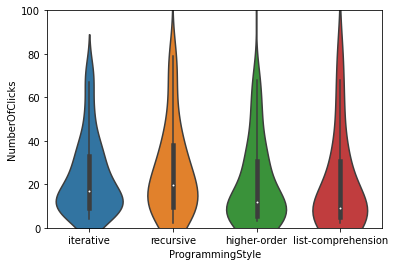

In [9]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "NumberOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="NumberOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 100.0));

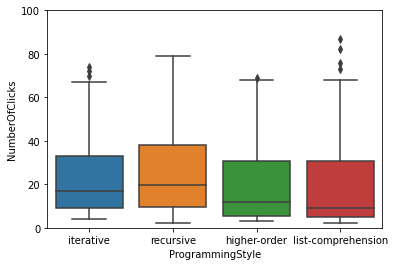

In [10]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "NumberOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.boxplot(x="ProgrammingStyle", y="NumberOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 100.0));

## Descriptive: Get Average Time of Clicks per Algorithm

In [11]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
df_visual[["Algorithm", "ProgrammingStyle", "AverageTimeOfClicks"]].groupby(
    ["Algorithm", "ProgrammingStyle"]).describe()

AverageTimeOfClicks                        \
                                               count       mean        std   
Algorithm     ProgrammingStyle                                               
LinkedList    higher-order                       5.0   3.870583   4.786513   
              iterative                          6.0   1.322143   0.315762   
              list-comprehension                 7.0   1.666785   0.665028   
              recursive                          6.0   2.871412   3.427894   
apply         higher-order                       8.0   3.044512   2.517295   
              iterative                          7.0   5.693800   6.896022   
              list-comprehension                 6.0  15.986319  26.145068   
              recursive                          7.0   2.278829   1.593352   
computer      higher-order                       7.0   2.481384   1.274106   
              iterative                          5.0   2.561939   1.110463   
              list-comprehension                 8.0   1.847289   0.584720   
              recursive                          4.0   6.992149   9.903901   
condition_sum higher-order                       5.0   8.328353  10.568145   
              iterative                          7.0   2.245018   0.716550   
              list-comprehension                 7.0   4.055946   1.762658   
              recursive                          6.0   2.582092   0.875142   
find          higher-order                       5.0   8.156059   7.688899   
              iterative                          7.0   2.245674   1.269006   
              list-comprehension                 6.0   4.746681   2.964698   
              recursive                          6.0   2.460136   2.023651   
is_prime      higher-order                       7.0   5.863747   6.851100   
              iterative                          9.0   2.895691   2.410473   
              list-comprehension                 5.0   2.037000   0.938687   
              recursive                          7.0   3.097253   2.870054   
max           higher-order                       8.0   3.377257   2.118235   
              iterative                          6.0   2.977039   2.396996   
              list-comprehension                 7.0   2.854884   1.355707   
              recursive                          7.0   3.875878   4.335688   
node          higher-order                       7.0   1.714489   0.472124   
              iterative                          7.0   1.694089   0.846538   
              list-comprehension                 5.0   2.575038   1.994722   
              recursive                          5.0   2.018593   0.974096   
prime_factors higher-order                       7.0   5.027794   3.789875   
              iterative                          6.0   3.045216   3.042379   
              list-comprehension                 6.0  11.336141  20.253148   
              recursive                          6.0   2.865086   0.921142   
quad_mul      higher-order                       5.0   5.589538   6.248374   
              iterative                          8.0   3.340192   2.945449   
              list-comprehension                 6.0   4.506165   3.229365   
              recursive                          6.0   4.022583   3.245806   
store         higher-order                       4.0   2.185366   1.759323   
              iterative                          6.0   3.878688   6.081055   
              list-comprehension                 6.0   1.476232   0.516884   
              recursive                          6.0   1.391671   0.135009   
students      higher-order                       7.0   2.411953   1.212797   
              iterative                          3.0   1.660441   0.224074   
              list-comprehension                 5.0   1.758567   0.524705   
              recursive                          6.0   2.597528   2.746571   
total         higher-order                      75.0   

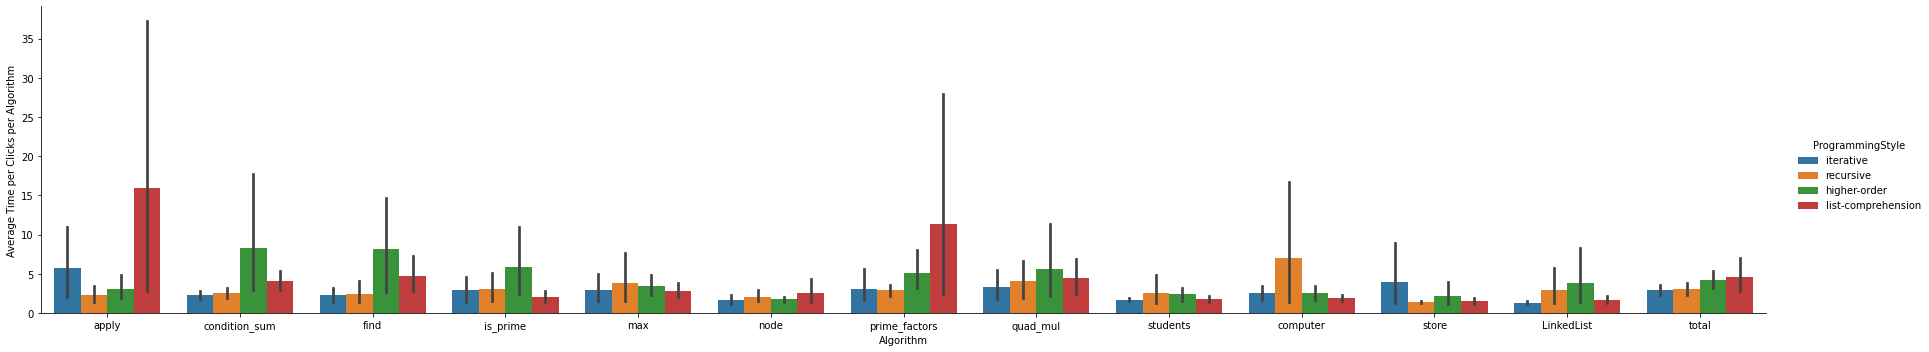

In [12]:
df_tmp = df.copy()
df_tmp["Algorithm"] = "total"
df_visual = df.append(df_tmp)
ax = sns.catplot(x="Algorithm", y="AverageTimeOfClicks", hue="ProgrammingStyle", data=df_visual, kind="bar", height=5,
                 aspect=5)
ax.tight_layout()
ax.set(ylabel='Average Time per Clicks per Algorithm');

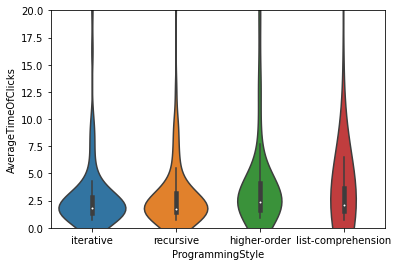

In [13]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "AverageTimeOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="AverageTimeOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 20.0));

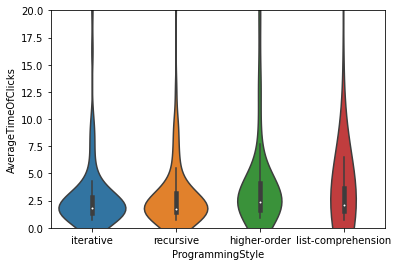

In [14]:
df_tmp = df_visual[["ProgrammingStyle", "Algorithm", "AverageTimeOfClicks"]]
df_tmp = df_tmp[df_tmp["Algorithm"] != "total"]
ax = sns.violinplot(x="ProgrammingStyle", y="AverageTimeOfClicks", data=df_tmp)
ax.set(ylim=(0.0, 20.0));


# Descriptive: Areas Of Interest

In [15]:
algorithms = df[["Algorithm"]].sort_values(by="Algorithm")["Algorithm"].unique()
programming_styles = df[["ProgrammingStyle"]].sort_values(by="ProgrammingStyle")["ProgrammingStyle"].unique()
algorithms = [x for x in algorithms]
programming_styles = [x.replace("-", "_") for x in programming_styles]

In [16]:
color_palette = sns.color_palette("hls", 15)
color_palette_mapping = {
    "Method" : color_palette[0],
    "MethodDeclaration" : color_palette[1],
    "MethodBody" : color_palette[2],
    "Helper" : color_palette[3],
    "HelperDeclaration" : color_palette[4],
    "HelperBody" : color_palette[5],
    "Iteration" : color_palette[6],
    "IterationHead" : color_palette[7],
    "IterationBody" : color_palette[8],
    "RecursiveCall" : color_palette[9],
    "HigherOrder" : color_palette[10],
    "ListComprehension" : color_palette[11],
    "InputPreparation" : color_palette[12],
    "StartOfAlgorithm" : color_palette[13],
    "Class" : color_palette[14],
}

In [17]:
aoi_numbers = {
    "Method" : 0,
    "MethodDeclaration" : 1,
    "MethodBody" : 2,
    "Helper" : 3,
    "HelperDeclaration" : 4,
    "HelperBody" : 5,
    "Iteration" : 6,
    "IterationHead" : 7,
    "IterationBody" : 8,
    "RecursiveCall" : 9,
    "HigherOrder" : 10,
    "ListComprehension" : 11,
    "InputPreparation" : 12,
    "StartOfAlgorithm" : 13,
    "Class" : 14,
}

#### Create bounding boxes for AOIS

In [18]:
#load file
df_bounding_box = pd.DataFrame(columns=["Algorithm", "ProgrammingStyle", "BoundingBoxes", "ImageDimension"])
image_path = "./results/aois/"
font_path="\\data\\fonts\\ttf\\"
offset = 3

def from_canvas(fig):
    lst = list(fig.canvas.get_width_height())
    lst.append(3)
    return PIL.Image.fromarray(np.frombuffer(fig.canvas.tostring_rgb(),dtype=np.uint8).reshape(lst))

for algorithm in tqdm(algorithms):
    for programming_style in programming_styles:
        # load the image and generate bb code info
        file_name = './data/CodeSnippets/Generators/' + algorithm + '_' + programming_style + '.json'
        try:
            image, result = snippets.create_image(file_name, font_path=font_path, lexer=PythonLexer)
            y, x = image.size[::-1]
            dimension = (x, y)
        except Exception as e:
            print(file_name + ":" + str(e))
            continue
        # extract the areas of interest in the image
        areas_of_interest = set()
        for letter in result:
            for aoi in letter["AOI"]:
                areas_of_interest.add(aoi)

        # create the bounding boxes
        disjoint_areas_of_interest = []
        for aoi in areas_of_interest:
            upper_left_x = 0
            upper_left_y = 0
            lower_right_x = 0
            lower_right_y = 0
            has_aoi = False
            for letter in result:
                if letter["BoundingBox"][0] == 0 and letter["BoundingBox"][1] == 0 and letter["BoundingBox"][2] == 0 and letter["BoundingBox"][3] == 0:
                    continue

                if aoi in letter["AOI"]:
                    if not has_aoi:
                        upper_left_x = letter["BoundingBox"][0] - offset
                        upper_left_y = letter["BoundingBox"][1] - offset
                        lower_right_x = letter["BoundingBox"][2] + offset
                        lower_right_y = letter["BoundingBox"][3] + offset
                        has_aoi = True
                    else:
                        upper_left_x = min(upper_left_x, letter["BoundingBox"][0] - offset)
                        upper_left_y = min(upper_left_y, letter["BoundingBox"][1] - offset)
                        lower_right_x = max(lower_right_x, letter["BoundingBox"][2] + offset)
                        lower_right_y = max(lower_right_y, letter["BoundingBox"][3] + offset)
                else:
                    if has_aoi:
                        disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))
                    has_aoi = False
                    upper_left_x = 0
                    upper_left_y = 0
                    lower_right_x = 0
                    lower_right_y = 0

            if has_aoi:
                disjoint_areas_of_interest.append((aoi, [upper_left_x, upper_left_y, lower_right_x, lower_right_y]))

        # create the bounding boxes without None aoi
        disjoint_areas_of_interest = [area for area in disjoint_areas_of_interest if area[0] != "None"]
        df_bounding_box = df_bounding_box.append(pd.DataFrame([[algorithm, programming_style.replace("_", "-"), disjoint_areas_of_interest, dimension]], columns=df_bounding_box.columns))

        # map a color to each aoi
        disjoint_areas_of_interest_visual = []
        for aoi, bounding_box in disjoint_areas_of_interest:
            h, s, l = color_palette_mapping[aoi]
            color = (h, s, l, 0.2)
            disjoint_areas_of_interest_visual.append((aoi, bounding_box, color))

        # create the image with the bounding boxes
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        ax.imshow(image, aspect='auto')

        for (aoi, bounding_box, color) in disjoint_areas_of_interest_visual:
            rect = patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2] - bounding_box[0],
                             bounding_box[3] - bounding_box[1], linewidth=1, edgecolor=color, facecolor=color)
            ax.add_patch(rect)

        fig, ax = plt.subplots(1, 1)
        ax.imshow(image)

        for (aoi, bounding_box, color) in disjoint_areas_of_interest_visual:
            rect = patches.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2] - bounding_box[0],
                             bounding_box[3] - bounding_box[1], linewidth=1, edgecolor=color, facecolor=color)
            ax.add_patch(rect)

        plt.tight_layout()
        plt.axis('off')
        plt.savefig(image_path + "/aoi_" + algorithm + '_' + programming_style + '.png', bbox_inches='tight', transparent=True, pad_inches=0)
        plt.close('all')

100%|██████████| 12/12 [00:14<00:00,  1.20s/it]


In [19]:
df_tmp = pd.merge(df_bounding_box, df, on=["Algorithm", "ProgrammingStyle"])
df = df_tmp

#### AOI coverage

In [20]:
from skimage.draw import ellipse, rectangle
def get_ellipse_mask(center, x_radius, y_radius, dimension, std_value = 1.0):
    """
    Returns a mask of an ellipse with the given center, x-radius, and y-radius.
    """
    x_dim = max(center[0]+2*x_radius+1, dimension[0])
    y_dim = max(center[1]+2*y_radius+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    rr, cc = ellipse(center[1], center[0], y_radius, x_radius)
    mask[rr, cc] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

def get_rectangular_mask(points, dimension, std_value = 1.0):
    """
    Returns a mask of a rectangular with the given points.
    """
    x_dim = max(points[2]+1, dimension[0])
    y_dim = max(points[3]+1, dimension[1])
    mask = np.zeros((y_dim, x_dim), dtype=np.float32)
    mask[points[1]:points[3]+1, points[0]:points[2]+1] = std_value
    mask = mask[:dimension[1], :dimension[0]]
    return mask

In [21]:
settings = json.load(open("./data/settings.json"))
x_radius = settings["radius_x"]+settings["grad_radius"]//2
y_radius = settings["radius_y"]+settings["grad_radius"]//2

In [22]:
df

,Algorithm,ProgrammingStyle,BoundingBoxes,ImageDimension,ID,ResponseTime,Correctness,ClickData,TimeData,NumberOfClicks,AverageTimeOfClicks
0,LinkedList,higher-order,"[(InputPreparation, [2, 811, 152, 1141]), (Cla...","(594, 1206)",204,193551,False,"[(70, 35), (64, 13), (75, 35), (102, 65), (111...","[4.092, 5.258, 6.324, 7.325, 8.131, 10.189, 11...",69,2.805087
1,LinkedList,higher-order,"[(InputPreparation, [2, 811, 152, 1141]), (Cla...","(594, 1206)",230,135938,True,"[(89, 918), (86, 948), (80, 1083), (169, 664),...","[80.344, 81.231, 85.489, 90.762, 92.445, 93.91...",11,12.358000
2,LinkedList,higher-order,"[(InputPreparation, [2, 811, 152, 1141]), (Cla...","(594, 1206)",264,68336,True,"[(148, 42), (145, 62), (144, 88), (151, 153), ...","[6.249, 6.797, 7.349, 13.618, 14.757, 17.117, ...",41,1.666732
3,LinkedList,higher-order,"[(InputPreparation, [2, 811, 152, 1141]), (Cla...","(594, 1206)",296,39427,True,"[(92, 38), (127, 147), (137, 162), (130, 222),...","[5.301, 7.147, 8.549, 9.339, 9.878, 11.086, 13...",31,1.271839
4,LinkedList,higher-order,"[(InputPreparation, [2, 811, 152, 1141]), (Cla...","(594, 1206)",313,58809,True,"[(54, 14), (87, 42), (98, 66), (106, 90), (96,...","[3.475, 3.99, 4.391, 4.758, 5.815, 6.206, 7.55...",47,1.251255
...,...,...,...,...,...,...,...,...,...,...,...
293,students,recursive,"[(RecursiveCall, [290, 343, 512, 364]), (Recur...","(514, 634)",238,33888,False,"[(89, 22), (98, 44), (109, 68), (116, 91), (13...","[2.963, 4.545, 5.113, 6.165, 7.287, 7.662, 12....",21,1.613714
294,students,recursive,"[(RecursiveCall, [290, 343, 512, 364]), (Recur...","(514, 634)",272,57062,False,"[(153, 508), (95, 585), (198, 506), (195, 535)...","[12.274, 15.248, 23.945, 24.997, 25.744, 32.46...",7,8.151714
295,students,recursive,"[(RecursiveCall, [290, 343, 512, 364]), (Recur...","(514, 634)",295,41656,True,"[(91, 24), (98, 41), (112, 66), (128, 94), (13...","[3.49, 3.96, 4.468, 4.947, 6.318, 6.795, 9.448...",23,1.811130
296,students,recursive,"[(RecursiveCall, [290, 343, 512, 364]), (Recur...","(514, 634)",297,32135,True,"[(83, 1), (89, 23), (104, 39), (117, 69), (126...","[5.012, 5.482, 6.047, 6.531, 7.074, 9.131, 9.6...",19,1.691316


In [24]:
from IPython.display import clear_output
import keyboard

df["TransitionMatrix"] = None
df["CountingMatrix"] = None
df["TransitionMatrix"] = df["TransitionMatrix"].apply(lambda x: np.zeros((len(aoi_numbers), len(aoi_numbers))))
df["CountingMatrix"] = df["CountingMatrix"].apply(lambda x: np.zeros(len(aoi_numbers)))
example = None
for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    dimension = row["ImageDimension"]
    clicks = row["ClickData"]
    bounding_boxes = row["BoundingBoxes"]
    mask_bounding_boxes = [get_rectangular_mask(bounding_box, dimension) for _, bounding_box in bounding_boxes]
    idx_bounding_boxes = [aoi_numbers[aoi_name] for aoi_name, _ in bounding_boxes]
    transition_matrix = np.zeros((len(aoi_numbers), len(aoi_numbers)))
    counting_matrix = np.zeros(len(aoi_numbers))
    current_aoi = []

    for click in clicks:
        elliptical_mask = get_ellipse_mask(click, x_radius, y_radius, dimension)
        next_aoi = []
        for idx_bounding_box, mask_bounding_box in zip(idx_bounding_boxes, mask_bounding_boxes):
            if np.max(mask_bounding_box+elliptical_mask) >= 2:
                next_aoi.append(idx_bounding_box)
        for aoi_idx in next_aoi:
            counting_matrix[aoi_idx] += 1

        combination_list = [(i, j) for i in current_aoi for j in next_aoi]
        for current_aoi_idx, next_aoi_idx in combination_list:
            transition_matrix[current_aoi_idx, next_aoi_idx] += 1

        current_aoi = [value for value in next_aoi]

    df.at[idx, "TransitionMatrix"] = transition_matrix
    df.at[idx, "CountingMatrix"] = counting_matrix

100%|██████████| 298/298 [01:01<00:00,  4.81it/s]


In [ ]:
from PIL import Image, ImageOps
from matplotlib.colors import ListedColormap

def get_alpha_blend_cmap(cmap, alpha):
    cls = plt.get_cmap(cmap)(np.linspace(0,1,256))
    cls = (1-alpha) + alpha*cls
    return ListedColormap(cls)

image = PIL.Image.open('./../Study/CodeSnippets/Snippets/LinkedList_higher_order.png')
dimension = df.iloc[0]["ImageDimension"]

cmap = plt.cm.get_cmap("jet")

example_tmp = example.copy()
example_tmp = np.flip(example_tmp, 0)
example_tmp = scipy.ndimage.gaussian_filter(example_tmp, sigma=settings["grad_radius"]//2)
max_value = np.max(example_tmp)
example_tmp = example_tmp/np.max(example_tmp)
example_tmp = example_tmp*255
example_tmp = example_tmp.astype(np.uint8)
example_tmp = cmap(example_tmp)
example_tmp = example_tmp*255
example_tmp = example_tmp.astype(np.uint8)


test_image = PIL.Image.fromarray(example_tmp).convert("RGBA")
image = image.convert("RGBA")

hmap = Image.blend(image, test_image, 0.5)
hmap = np.array(hmap)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
fig.set_size_inches(dimension[0]/100 * 1.1, dimension[1]/100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=max_value))
plt.rcParams['savefig.facecolor']='white'
plt.axis('off')
plt.tight_layout()
ax.imshow(hmap, aspect='auto')
plt.colorbar(sm, fraction=0.046, pad=0.04)
plt.savefig('./test.png', bbox_inches='tight' , pad_inches=0)
plt.close('all')